In [1]:
from pathlib import Path
results_dir = Path('../results/')

In [2]:
import matplotlib.pyplot as plt

In [3]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.images.shape

(1797, 8, 8)

In [4]:
print(digits['DESCR'])

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 1797
:Number of Attributes: 64
:Attribute Information: 8x8 image of integer pixels in the range 0..16.
:Missing Attribute Values: None
:Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
:Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an in

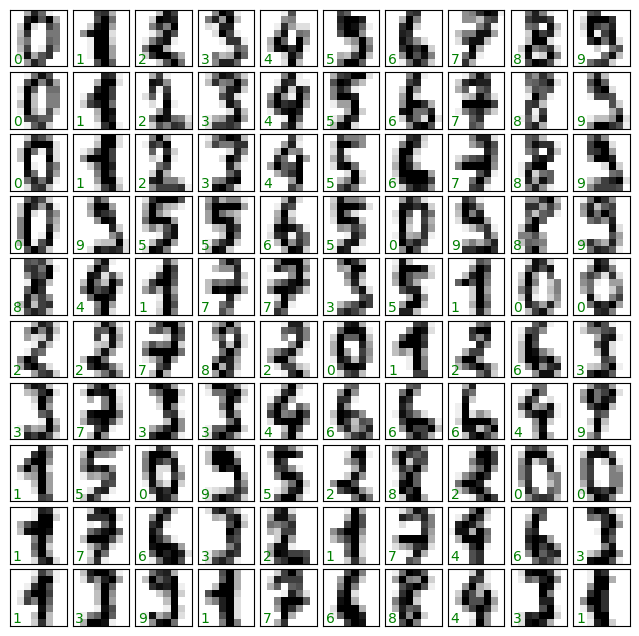

In [5]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks': [], 'yticks': []},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(digits.target[i]),
            transform=ax.transAxes, color='green')

In [6]:
digits.data[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

In [7]:
X = digits.data
X.shape

(1797, 64)

In [8]:
y = digits.target
y.shape

(1797,)

## Create and train the classifier

In [9]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0)

In [10]:
Xtrain.shape, Xtest.shape

((1347, 64), (450, 64))

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, top_k_accuracy_score, ConfusionMatrixDisplay

In [12]:
clf = make_pipeline(StandardScaler(),
                    MLPClassifier(
                        random_state=1,
                        max_iter=2000,
                        early_stopping=True,
                        hidden_layer_sizes=[16, 16]
                    ))

In [13]:
clf

,steps,"[('standardscaler', ...), ('mlpclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,hidden_layer_sizes,"[16, 16]"
,activation,'relu'
,solver,'adam'
,alpha,0.0001


In [14]:
%%time
clf.fit(Xtrain, ytrain)

CPU times: user 129 ms, sys: 3.06 ms, total: 132 ms
Wall time: 131 ms


,steps,"[('standardscaler', ...), ('mlpclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,hidden_layer_sizes,"[16, 16]"
,activation,'relu'
,solver,'adam'
,alpha,0.0001


Just checking activation functions used by the classifier.

In [15]:
print("Activation function:", clf[-1].activation)
print("Output activation function:", clf[-1].out_activation_)

Activation function: relu
Output activation function: softmax


In [37]:
clf[-1].n_iter_

47

The classifier was fitted for 47 epochs (validation score didn't improve for the last 10 epochs, determining early stopping).

Text(0.5, 0, 'Training epoch')

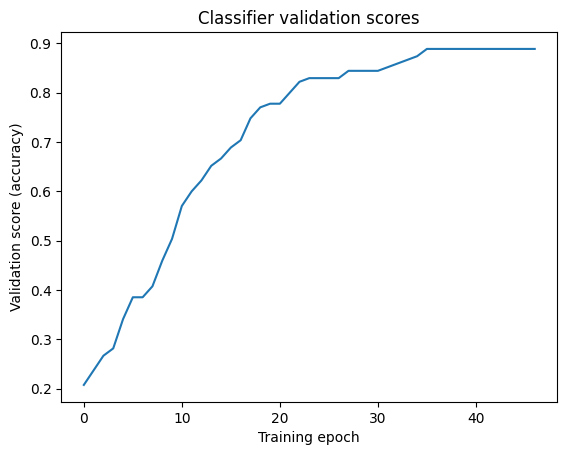

In [16]:
plt.plot(clf[-1].validation_scores_)
plt.title("Classifier validation scores")
plt.ylabel("Validation score (accuracy)")
plt.xlabel("Training epoch")

In [17]:
ypred = clf.predict(Xtest)
print("Accuracy score:", accuracy_score(ytest, ypred))

Accuracy score: 0.88


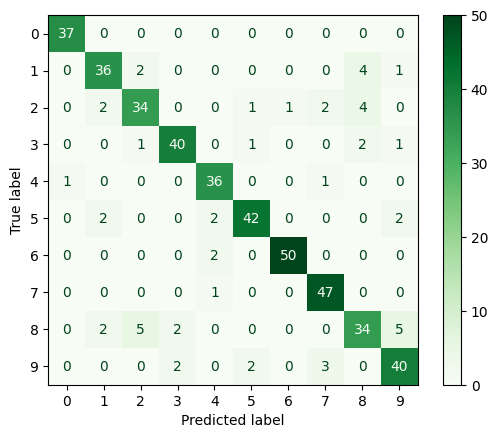

In [18]:
ConfusionMatrixDisplay.from_predictions(ytest, ypred, cmap='Greens')

In [19]:
pred_proba = clf.predict_proba(Xtest)
pred_proba[0]

array([5.79750730e-05, 1.59257524e-02, 7.66746212e-01, 2.17198168e-03,
       6.65769370e-03, 5.16971827e-02, 1.74864286e-03, 1.21512375e-01,
       3.14336777e-02, 2.04850738e-03])

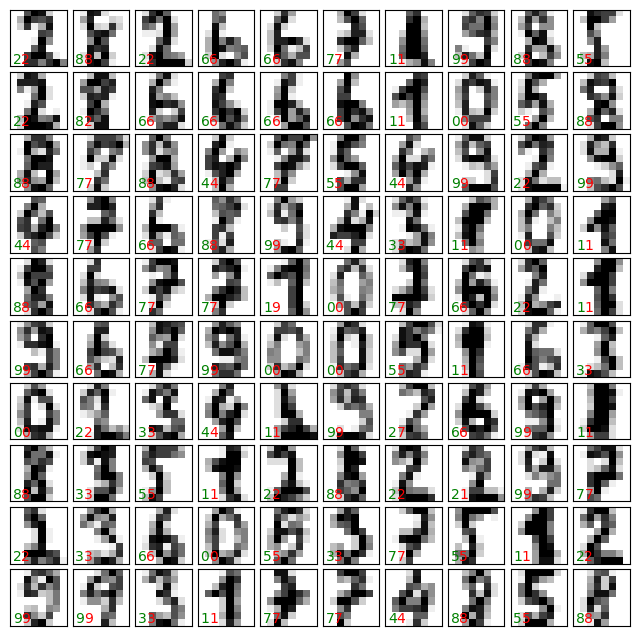

In [20]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks': [], 'yticks': []},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    ax.imshow(Xtest[i].reshape(8, 8), cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(ytest[i]),
            transform=ax.transAxes, color='green')
    ax.text(0.2, 0.05, str(ypred[i]),
            transform=ax.transAxes, color='red')

Since accuracy is not really impressive, we check also top-2 accuracy.

In [21]:
print("Top-2 accuracy score:", round(top_k_accuracy_score(ytest, pred_proba, k=2), 3))

Top-2 accuracy score: 0.947


## Export images for visualization

In [22]:
import json

In [23]:
examples = [17, 2, 4, 44]
digits = [
    {
    "img": [round(float(value), 2) for value in Xtest[example]],
    "proba": [round(float(value), 2) for value in pred_proba[example]],
    "label": int(ytest[example])
    }
    for example
    in examples]

In [24]:
with open(results_dir / 'digits.json', 'w') as outfile:
    json.dump(digits, outfile)

## Export weights for visualization

In [25]:
params = clf[-1].coefs_
for layer in params:
    print(layer.shape)

(64, 16)
(16, 16)
(16, 10)


In [26]:
edges = []
for source_index, source in enumerate(params[0]):
    for target_index, target in enumerate(source):
        link = {
            'source': f"x{source_index +1}",
            'target': f"h{target_index + 1}",
            'weight': round(float(target), 3)
        }
        edges.append(link)
for source_index, source in enumerate(params[1]):
    for target_index, target in enumerate(source):
        link = {
            'source': f'h{source_index + 1}',
            'target': f'k{target_index + 1}',
            'weight': round(float(target), 3)
        }
        edges.append(link)
for source_index, source in enumerate(params[2]):
    for target_index, target in enumerate(source):
        link = {
            'source': f"k{source_index + 1}",
            'target': f"o{target_index + 1}",
            'weight': round(float(target), 3)
        }
        edges.append(link)
edges[-10:]

[{'source': 'k16', 'target': 'o1', 'weight': 0.526},
 {'source': 'k16', 'target': 'o2', 'weight': -0.426},
 {'source': 'k16', 'target': 'o3', 'weight': -0.37},
 {'source': 'k16', 'target': 'o4', 'weight': -0.178},
 {'source': 'k16', 'target': 'o5', 'weight': -0.648},
 {'source': 'k16', 'target': 'o6', 'weight': -0.547},
 {'source': 'k16', 'target': 'o7', 'weight': -0.072},
 {'source': 'k16', 'target': 'o8', 'weight': -0.692},
 {'source': 'k16', 'target': 'o9', 'weight': 0.03},
 {'source': 'k16', 'target': 'o10', 'weight': 0.234}]

In [27]:
nodes = ([{'id': f'x{i}', 'layer': 1, 'order': i} for i in range(1, 64 + 1)] +
         [{'id': f'h{i}', 'layer': 2, 'order': i} for i in range(1, 16 +1)] +
         [{'id': f'k{i}', 'layer': 3, 'order': i} for i in range(1, 16 +1)] +
         [{'id': f'o{i}', 'layer': 4, 'order': i} for i in range(1, 10 + 1)])
nodes[-15:]

[{'id': 'k12', 'layer': 3, 'order': 12},
 {'id': 'k13', 'layer': 3, 'order': 13},
 {'id': 'k14', 'layer': 3, 'order': 14},
 {'id': 'k15', 'layer': 3, 'order': 15},
 {'id': 'k16', 'layer': 3, 'order': 16},
 {'id': 'o1', 'layer': 4, 'order': 1},
 {'id': 'o2', 'layer': 4, 'order': 2},
 {'id': 'o3', 'layer': 4, 'order': 3},
 {'id': 'o4', 'layer': 4, 'order': 4},
 {'id': 'o5', 'layer': 4, 'order': 5},
 {'id': 'o6', 'layer': 4, 'order': 6},
 {'id': 'o7', 'layer': 4, 'order': 7},
 {'id': 'o8', 'layer': 4, 'order': 8},
 {'id': 'o9', 'layer': 4, 'order': 9},
 {'id': 'o10', 'layer': 4, 'order': 10}]

In [28]:
network = {
    'nodes': nodes,
    'links': edges
}

In [29]:
with open(results_dir / 'network.json', 'w') as outfile:
    json.dump(network, outfile)